In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


In [2]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPool1D, Activation, Add

from keras.models import Model, Sequential
from keras.layers import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [4]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Setting the working directory
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [6]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [7]:
# Importing ByteDance dataset

le = LabelEncoder()
le2 = LabelEncoder()

# Train set
train_df = pd.read_csv('data/train_bd_with_labels_2nd.csv')
print(train_df.columns)
train_df['bd_label'] = le.fit_transform(train_df['bd_label']) # agreed = 0, disagreed = 1
train_df['single_new_emo'] = le2.fit_transform(train_df['single_new_emo']) # emotions agree = 0, disagree = 1
train_df.head()

# Test set
test_df = pd.read_csv('data/test_bd_with_labels.csv')
print(test_df.columns)
test_df['bd_label'] = le.transform(test_df['bd_label'])
test_df['single_new_emo'] = le2.transform(test_df['single_new_emo'])
test_df.head()

Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')
Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'test_wts', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')


,id,title1_en,title2_en,bd_label,quora_label,Premise_Emotion_Label,Hypothesis_Emotion_Label,com_femotion,femotion,NV_Orc,EM_Orc,weights,test_wts,single_new_emo,premise_emo,hypothesis_emo,novelty_label
0,321198,wanda collapses: china 's richest man wang jia...,news: the detention of wang jianlin and his fa...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
1,321201,wanda collapses: china 's richest man wang jia...,wang jian 's family is detained,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
2,321200,wanda collapses: china 's richest man wang jia...,Exclusive news: Wang Jian-lin is detained in a...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
3,321202,wanda collapses: china 's richest man wang jia...,prc: wang jianlin and his family are detained ...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
4,321205,"The land price 130 thousand, now only needs 33...","$160,000 on the floor. Now it's only $100,000....",0,1,0,0,1,1,1,1,0.544454,0.066667,0,1,1,1


In [8]:
# Importing BERT embeddings
pre_bert_bd = np.load("bert/pre_bert_bd.npy")
hyp_bert_bd = np.load("bert/hyp_bert_bd.npy")
print('Premise', pre_bert_bd.shape)
print('Hypothesis', hyp_bert_bd.shape)

Premise (80992, 768)
Hypothesis (80992, 768)


In [9]:
pre_bert_bd_test = np.load("bert/pre_bert_test_bd.npy")
hyp_bert_bd_test = np.load("bert/hyp_bert_test_bd.npy")
print('Premise', pre_bert_bd_test.shape)
print('Hypothesis', hyp_bert_bd_test.shape)

Premise (28746, 768)
Hypothesis (28746, 768)


In [10]:
# Importing auxiliary features
pre_features_bd = np.load("new_features/pre_features_train_bd.npy")
hyp_features_bd = np.load("new_features/hyp_features_train_bd.npy")
print('Premise', pre_features_bd.shape)
print('Hypothesis', hyp_features_bd.shape)

Premise (80992, 16)
Hypothesis (80992, 16)


In [11]:
pre_features_bd_test = np.load("new_features/pre_features_test_bd.npy")
hyp_features_bd_test = np.load("new_features/hyp_features_test_bd.npy")
print('Premise', pre_features_bd_test.shape)
print('Hypothesis', hyp_features_bd_test.shape)

Premise (28746, 16)
Hypothesis (28746, 16)


In [12]:
train_lst_1 = train_df['title1_en'].tolist()
train_lst_2 = train_df['title2_en'].tolist()
uq_tr_1 = list(set(train_lst_1))
uq_tr_2 = list(set(train_lst_2))
train_merged = uq_tr_1 + uq_tr_2
print('Train length is', len(train_merged))

test_lst_1 = test_df['title1_en'].tolist()
test_lst_2 = test_df['title2_en'].tolist()
uq_ts_1 = list(set(test_lst_1))
uq_ts_2 = list(set(test_lst_2))
test_merged = uq_ts_1 + uq_ts_2
print('Test length is', len(test_merged))

total_dataset = train_merged + test_merged
print('Total dataset length is', len(total_dataset))

Train length is 67950
Test length is 25300
Total dataset length is 93250


In [13]:
train_max_1 = max([len(s) for s in train_lst_1])
train_max_2 = max([len(s) for s in train_lst_2])
train_avg_1 = int(np.average([len(s) for s in train_lst_1]))
train_avg_2 = int(np.average([len(s) for s in train_lst_2]))
train_min_1 = min([len(s) for s in train_lst_1])
train_min_2 = min([len(s) for s in train_lst_2])
print("Train set: ")
print('title1_en -> Max: ', train_max_1, 'Avg: ', train_avg_1, 'Min: ', train_min_1)
print('title2_en -> Max: ', train_max_2, 'Avg: ', train_avg_2, 'Min: ', train_min_2)
test_max_1 = max([len(s) for s in test_lst_1])
test_max_2 = max([len(s) for s in test_lst_2])
test_avg_1 = int(np.average([len(s) for s in test_lst_1]))
test_avg_2 = int(np.average([len(s) for s in test_lst_2]))
test_min_1 = min([len(s) for s in test_lst_1])
test_min_2 = min([len(s) for s in test_lst_2])
print("\nTest set: ")
print('title1_en -> Max: ', test_max_1, 'Avg: ', test_avg_1, 'Min: ', test_min_1)
print('title2_en -> Max: ', test_max_2, 'Avg: ', test_avg_2, 'Min: ', test_min_2)

MAX_LENGTH = 100

Train set: 
title1_en -> Max:  1577 Avg:  93 Min:  6
title2_en -> Max:  4002 Avg:  94 Min:  1

Test set: 
title1_en -> Max:  1050 Avg:  94 Min:  6
title2_en -> Max:  1050 Avg:  95 Min:  1


In [14]:
# Pre-processing data
import string
!pip install nltk
import nltk
from nltk.tokenize import  word_tokenize

contr_dict = {"i\'m" : "i am",
            "won\'t" : "will not",
            "it\'s" : "it is",
            " \'" : " ",
            "\' " : " ",
            "\'s" : "",
            " \'s" : "",
            " s " : " ",
            "\'ll" : "will",
            "\'ve" : "have",
            "n\'t" : "not",
            "\'re" : "are",
            "\'d" : "would",
            "y'all" : "all of you"}

known_typos = dict()

def encode_char(text):
    text = text.replace(u"\u201d",'"') # replace unicode quotation
    text = text.replace(u"\u201c",'"')
    text = text.replace(u"\u2018","'")
    text = text.replace(u"\u2019","'")
    if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
      print(text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()
    return text

def correct_typos(text):
    text = text + " "
    for typo in known_typos:
      text = text.replace(typo, " "+known_typos[typo])
    return text

def remove_html(text):
    text = text.replace("< i >", "")
    text = text.replace("< / i >", "")
    return text

def remove_numbers(text):
    no_digits = ""
    for i in text:
        if not i.isdigit():
            no_digits += i
    return no_digits

def remove_punctuation(text):
    punctuationfree = ""
    for i in range(len(text)):
      if text[i] not in string.punctuation:
        punctuationfree += text[i]
      else:
        if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
          punctuationfree += " "
    return punctuationfree

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(stopwords, tokens):
    result = [t for t in tokens if t not in stopwords]
    return result

def tokens_to_text(tokens):
    result = " ".join(t for t in tokens)
    return result

# remove apostrophes and replaces contractions with full words
def replace_contractions(text, contr_dict=contr_dict):
    text = text.lower()
    for char in ["′","ʼ","`","՚","ʼ","ߴ","ߵ","＇", '“','”',"\'", "’", "‘"]:
      text = text.replace(char, "\'")
    for contr in contr_dict:
      text = text.replace(contr, " "+contr_dict[contr])
    return text

def text_preprocessing(texts):
  new_texts = []
  for text in texts:
      # text = encode_char(text)
      text = remove_html(text)
      text = remove_numbers(text)
      text = replace_contractions(text)
      # text = remove_punctuation(text)
      # text = correct_typos(text)
      # tokens =  tokenization(text)
      # stopwords = nltk.corpus.stopwords.words('english')
      # tokens = remove_stopwords(stopwords, tokens)
      # text = tokens_to_text(tokens)
      new_texts.append(text)
  return new_texts

total_dataset = text_preprocessing(total_dataset)

In [15]:
# Defining tokenizer
def get_tokenizer(vocabulary_size):
  print('Training tokenizer...')
  tokenizer = Tokenizer(num_words = vocabulary_size)
  tweet_text = []
  print('Read {} Sentences'.format(len(total_dataset)))
  tokenizer.fit_on_texts(total_dataset)
  return tokenizer

In [16]:
def process_glove_line(line, dim):
    word = None
    embedding = None
    try:
      splitLine = line.split()
      word = " ".join(splitLine[:len(splitLine)-dim])
      embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
      print(line)
    return word, embedding

# Getting the embedding matrix
def get_embeddings():
  print('Generating embeddings matrix...')
  embeddings_file = 'glove.6B.300d.txt'
  embeddings_index = dict()
  with open(embeddings_file, 'r', encoding="utf-8") as infile:
    for line in infile:
      word, vector = process_glove_line(line, 300)
      embeddings_index[word] = vector
	# Creating weight matrix for words
  vocabulary_size = len(embeddings_index)
  embeddinds_size = list(embeddings_index.values())[0].shape[0]
  print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
  tokenizer = get_tokenizer(vocabulary_size)
  embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
  considered = 0
  total = len(tokenizer.word_index.items())
  oov = [] # out of vocabulary
  for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
      print(word, index)
      continue
    else:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        considered += 1
      else:
         oov.append(word)
  print('Considered ', considered, 'Left ', total - considered)
  return embedding_matrix, tokenizer, embeddings_index, oov

In [17]:
def get_data(tokenizer, MAX_LENGTH, input_df):
  print('Loading data')
  X1, X2, Y = [], [], []
  X1 = input_df['title1_en'].tolist()
  X2 = input_df['title2_en'].tolist()
  X1 = text_preprocessing(X1)
  X2 = text_preprocessing(X2)
  Y_em = input_df['single_new_emo'].tolist()
  Y_bd = input_df['bd_label'].tolist()
  assert len(X1) == len(X2) == len(Y_em) == len(Y_bd)
  sequences_1 = tokenizer.texts_to_sequences(X1)
  sequences_2 = tokenizer.texts_to_sequences(X2)
  X1 = pad_sequences(sequences_1, maxlen=MAX_LENGTH)
  X2 = pad_sequences(sequences_2, maxlen=MAX_LENGTH)
  Y_em = np.array(Y_em)
  Y_bd = np.array(Y_bd)
  return X1, X2, Y_em, Y_bd

In [18]:
embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

Generating embeddings matrix...
Vocabulary = 400000, embeddings = 300
Training tokenizer...
Read 93250 Sentences
Considered  20896 Left  4009


In [19]:
#print(tokenizer.word_index)

In [20]:
# Get frequencies of oov words
def get_oov_freq(oov, total_dataset):
  oov_freq = dict()
  for s in total_dataset:
    for word in oov:
      count = s.count(word)
      if count > 0:
        try:
          oov_freq[word] += count
        except KeyError:
          oov_freq[word] = count
  return oov_freq

def show_oov_words(oov_freq, num_to_show=30):
    # Sort oov words by their frequency in the text
    sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
    # Show oov words and their frequencies
    if (len(sorted_oov)>0):
        print("oov words:")
        for pair in sorted_oov[:num_to_show]:
          print("%s\t%s"%(pair[0], pair[1]))
    else:
        print("No words were out of vocabulary.")
    return len(sorted_oov)

In [21]:
# oov_freq = get_oov_freq(oov, total_dataset)
# oov_len = show_oov_words(oov_freq, 100)

In [22]:
X1, X2, Y_em, Y_bd = get_data(tokenizer, MAX_LENGTH, train_df)

Loading data


Class balance for train data: 


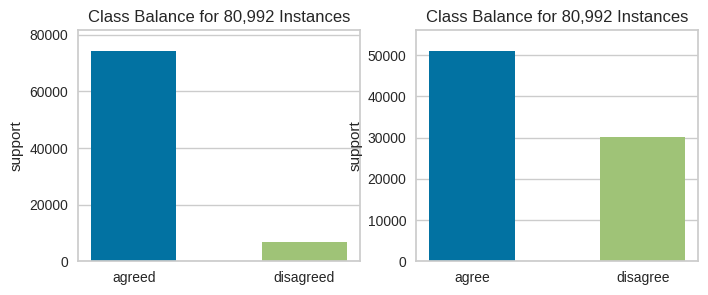

In [23]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,3))

classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd)
visualiser_bd.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax2) # 0 = agree, 1 = disagree
visualiser_em.fit(Y_em)
visualiser_em.finalize()

In [24]:
print("BD train data class balance: ")
unique, counts = np.unique(Y_bd, return_counts=True)
dict(zip(unique, counts))

BD train data class balance: 


{0: 74177, 1: 6815}

In [25]:
X1_test, X2_test, Y_em_test, Y_bd_test = get_data(tokenizer, MAX_LENGTH, test_df)

Loading data


Class distribution for test data: 


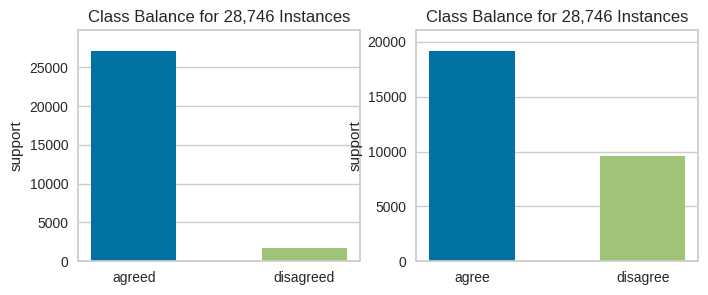

In [26]:
print("Class distribution for test data: ")
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd_test)
visualiser_bd.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax2)
visualiser_em.fit(Y_em_test)
visualiser_em.finalize()

In [27]:
print("BD test data class balance: ")
unique, counts = np.unique(Y_bd_test, return_counts=True)
dict(zip(unique, counts))

BD test data class balance: 


{0: 27075, 1: 1671}

In [28]:
# Scaffold labels
emotion_true = embeddings_index['anticipation']+embeddings_index['sadness']+embeddings_index['joy']+embeddings_index['trust']
emotion_false = embeddings_index['anger']+embeddings_index['fear']+embeddings_index['disgust']+embeddings_index['surprise']

In [29]:
# Emotion Bias
train_bias_em = []
test_bias_em = []
zero_vector = np.zeros((300,))

for i in range(len(train_df)):
    em_lab = train_df.loc[i, 'single_new_emo']
    if train_df.loc[i, 'bd_label'] == 0 and em_lab == 0:
        train_bias_em.append(emotion_false)
    elif train_df.loc[i, 'bd_label'] == 1 and em_lab == 1:
        train_bias_em.append(emotion_true)
    else:
        train_bias_em.append(zero_vector)

for i in range(len(test_df)):
    em_lab = test_df.loc[i, 'single_new_emo']
    if test_df.loc[i, 'bd_label'] == 0 and em_lab == 0:
        test_bias_em.append(emotion_false)
    elif test_df.loc[i, 'bd_label'] == 1 and em_lab == 1:
        test_bias_em.append(emotion_true)
    else:
        test_bias_em.append(zero_vector)

train_bias_em = np.stack(train_bias_em)
test_bias_em = np.stack(test_bias_em)
print('Train bias', train_bias_em.shape)
print('Test bias', test_bias_em.shape)

Train bias (80992, 300)
Test bias (28746, 300)


In [30]:
# Creating one-hot encodings
y_train_em = keras.utils.to_categorical(Y_em)
# print(y_train_em)
y_train_bd = keras.utils.to_categorical(Y_bd)
# print(y_train_bd)
y_test_em = keras.utils.to_categorical(Y_em_test)
# print(y_test_em)
y_test_bd = keras.utils.to_categorical(Y_bd_test)
# print(y_test_bd)

In [31]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
x2_train, x2_val, \
x1_train_bert, x1_val_bert, \
x2_train_bert, x2_val_bert, \
x1_train_features, x1_val_features, \
x2_train_features, x2_val_features, \
y_train_em, y_val_em, \
y_train_bd, y_val_bd, \
train_bias_em, val_bias_em = \
    train_test_split(
        X1, X2,
        pre_bert_bd, hyp_bert_bd,
        pre_features_bd, hyp_features_bd,
        y_train_em, y_train_bd,
        train_bias_em,
        test_size=VALIDATION_RATIO,
        random_state=RANDOM_STATE
)

In [32]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"x1_train_bert : {x1_train_bert.shape}")
print(f"x2_train_bert : {x2_train_bert.shape}")
print(f"x1_train_features : {x1_train_features.shape}")
print(f"x2_train_features : {x2_train_features.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"x1_val_bert:   {x1_val_bert.shape}")
print(f"x2_val_bert :   {x2_val_bert.shape}")
print(f"x1_val_features:   {x1_val_features.shape}")
print(f"x2_val_features :   {x2_val_features.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (72892, 100)
x2_train: (72892, 100)
x1_train_bert : (72892, 768)
x2_train_bert : (72892, 768)
x1_train_features : (72892, 16)
x2_train_features : (72892, 16)
----------
x1_val:   (8100, 100)
x2_val:   (8100, 100)
x1_val_bert:   (8100, 768)
x2_val_bert :   (8100, 768)
x1_val_features:   (8100, 16)
x2_val_features :   (8100, 16)
----------
Test Set


In [33]:
NUM_CLASSES = 2

MAX_SEQUENCE_LENGTH = MAX_LENGTH

NUM_LSTM_UNITS = 150
NUM_GRU_UNITS = 150

MAX_NUM_WORDS = embedding_matrix.shape[0]

NUM_EMBEDDING_DIM = embedding_matrix.shape[1]

In [34]:
class AttentionLayer(Layer):

    def __init__(self,attention_dim=300,return_coefficients=True,**kwargs):
        # Initializer
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def call(self, hit, mask=None):
        # uit = annotations
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        # ait = importance weights per word
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1) # into 1D array
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

In [35]:
# Result Labels
res_df = pd.DataFrame()

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):

    # Loss
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    losses = ['bd_loss','em_loss']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      i += 1

    plt.show()

    # Accuracy
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    losses = ['bd_accuracy','em_accuracy']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'b')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      i += 1

    plt.show()

In [37]:
import matplotlib.pyplot as plt
import itertools

# print confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:
## Multitask model for disagreement detection and emotion recognition

glove_input_pre = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='pre_input') # premise (glove)
glove_input_hyp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='hyp_input') # hypothesis (glove)

bert_input_pre = Input(shape=(768, ), dtype='float32', name='pre_input_bert') # premise (bert)
bert_input_hyp = Input(shape=(768, ), dtype='float32', name='hyp_input_bert') # hypothesis (bert)

bias_input_em = Input(shape = (300, ),dtype = 'float32', name='bias_input_em')

aux_input_pre = Input(shape=(16, ), dtype='float32', name='pre_aux_features') # lexicon and other features (for premise)
aux_input_hyp = Input(shape=(16, ), dtype='float32', name='hyp_aux_features') # lexicon and other features (for hypothesis)


# GloVe Emdeddings
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True, name='embedding')
glove_embed_pre = embedding_layer(glove_input_pre)
glove_embed_hyp = embedding_layer(glove_input_hyp)

# first Bi-LSTM
glove_lstm_1st = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="lstm_1"), name="bi_1")
glove_lstm_out_pre = glove_lstm_1st(glove_embed_pre)
glove_lstm_out_hyp = glove_lstm_1st(glove_embed_hyp)
# glove_gru_1st = Bidirectional(GRU(NUM_GRU_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="gru_1"), name="bi_1")
# glove_gru_out_pre = glove_gru_1st(glove_embed_pre)
# glove_gru_out_hyp = glove_gru_1st(glove_embed_hyp)

# concatenating hidden representations of premise and hypothesis
pre_hyp_comb_glove = concatenate([glove_lstm_out_pre, glove_lstm_out_hyp],axis=-1, name='concat_pre_hyp')
# pre_hyp_comb_glove = concatenate([glove_gru_out_pre, glove_gru_out_hyp],axis=-1, name='concat_pre_hyp')

# second Bi-LSTM
glove_lstm_2nd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="lstm_2"), name="bi_2")
(glove_lstm_out, forward_h, forward_c, backward_h, backward_c) = glove_lstm_2nd(pre_hyp_comb_glove)
# glove_gru_2nd = Bidirectional(GRU(NUM_GRU_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="gru_2"), name="bi_2")
# (glove_gru_out, forward_h, backward_h) = glove_gru_2nd(pre_hyp_comb_glove)

# attention layer
seq_att, seq_coeffs = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention')(glove_lstm_out)
# seq_att, seq_coeffs = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention')(glove_gru_out)
context_vector_gl = Dropout(0.4,name='dropout')(seq_att)



# BERT Embeddings
bert_embed_pre = Reshape((1, 768, ), name='reshape_pre_bert')(bert_input_pre)
bert_embed_hyp = Reshape((1, 768, ), name='reshape_hyp_bert')(bert_input_hyp)

# first Bi-LSTMs
bert_lstm_1st = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="lstm_bert_1"), name='bi_bert_1')
bert_lstm_out_pre = bert_lstm_1st(bert_embed_pre)
bert_lstm_out_hyp = bert_lstm_1st(bert_embed_hyp)
# bert_gru_1st = Bidirectional(GRU(NUM_GRU_UNITS, return_sequences=True, recurrent_dropout = 0.3, name="gru_bert_1"), name="bi_bert_1")
# bert_gru_out_pre = bert_gru_1st(bert_embed_pre)
# bert_gru_out_hyp = bert_gru_1st(bert_embed_hyp)

# concatenating hidden representations of premise and hypothesis
pre_hyp_comb_bert = concatenate([bert_lstm_out_pre, bert_lstm_out_hyp],axis=-1,name='concat_pre_hyp_bert')
# pre_hyp_comb_bert = concatenate([bert_gru_out_pre, bert_gru_out_hyp],axis=-1,name='concat_pre_hyp_bert')

# second Bi-LSTM
bert_lstm_2nd = Bidirectional(LSTM(NUM_LSTM_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="lstm_bert_2"),name='bi_bert_2')
(bert_lstm_out, forward_h, forward_c, backward_h, backward_c) = bert_lstm_2nd(pre_hyp_comb_bert)
# bert_gru_2nd = Bidirectional(GRU(NUM_GRU_UNITS, return_sequences=True, return_state=True, activation='tanh', recurrent_dropout = 0.3, name="gru_bert_2"), name="bi_bert_2")
# (bert_gru_out, forward_h, backward_h) = bert_gru_2nd(pre_hyp_comb_bert)

# attention layer
seq_att_bt, seq_coeffs_bt = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention_bert')(bert_lstm_out)
# seq_att_bt, seq_coeffs_bt = AttentionLayer(NUM_EMBEDDING_DIM,return_coefficients=True,name='attention_bert')(bert_gru_out)
context_vector_bt = Dropout(0.4,name='dropout_bert')(seq_att_bt)



# concatenate new features of premise and hypothesis
comb_aux_features = concatenate([aux_input_pre, aux_input_hyp], name='concat_pre_hyp_aux')



# concatenation layer

# emotion recognition
comb_features_em = concatenate([context_vector_gl+context_vector_bt, \
                                context_vector_gl-context_vector_bt, \
                                context_vector_gl*context_vector_bt, \
                                # comb_aux_features],axis=-1, name='concat_em_features')
                                ],axis=-1, name='concat_em_features')

# disagreement detection
comb_features_bd = concatenate([context_vector_gl+context_vector_bt, \
                                 context_vector_gl*context_vector_bt, \
                                #  comb_aux_features],axis=-1, name='concat_bd_features')
                                ],axis=-1, name='concat_bd_features')



# task-specific networks
pre_em = Dense(units=64, activation='tanh', name = 'dense_em')(comb_features_em)
pre_bd = Dense(units=64, activation='tanh',name = 'dense_bd')(comb_features_bd)

# prediction
dense_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'em')
dense_bd =  Dense(units=NUM_CLASSES, activation='softmax',name = 'bd')

# outputs
predictions_em = dense_em(pre_em)
predictions_bd = dense_bd(pre_bd)

model_bd = Model(
    inputs=[glove_input_pre, glove_input_hyp, bert_input_pre, bert_input_hyp, aux_input_pre, aux_input_hyp, bias_input_em],
    outputs=[predictions_em, predictions_bd])

model_bd.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pre_input (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 hyp_input (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 pre_input_bert (InputLayer  [(None, 768)]                0         []                            
 )                                                                                                
                                                                                                  
 hyp_input_bert (InputLayer  [(None, 768)]                0         []                        

In [39]:
from keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_bd.compile(
    optimizer=opt,
    loss={'em':'categorical_crossentropy', 'bd':'categorical_crossentropy'},
    loss_weights={'em':1, 'bd':1},
    metrics=['accuracy'])
keras.utils.plot_model(model_bd, "model_bilstm_dg_em_bd.png", show_shapes=True)
checkpointer = ModelCheckpoint(filepath='multitask_dg_em_bd.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
# Disagreement detection and emotion recognition
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_bd.fit(x=[x1_train, x2_train, x1_train_bert, x2_train_bert, x1_train_features, x2_train_features, train_bias_em],
                    y=[y_train_em, y_train_bd],
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val, x1_val_bert, x2_val_bert, x1_val_features, x2_val_features, val_bias_em],
                      [y_val_em, y_val_bd]
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
285/285 [==============================] - 506s 2s/step - loss: 0.2622 - em_loss: 0.6604 - bd_loss: 0.0916 - em_accuracy: 0.6234 - bd_accuracy: 0.9727 - val_loss: 0.2285 - val_em_loss: 0.6484 - val_bd_loss: 0.0485 - val_em_accuracy: 0.6316 - val_bd_accuracy: 0.9860
Epoch 2/50
285/285 [==============================] - 473s 2s/step - loss: 0.2078 - em_loss: 0.6179 - bd_loss: 0.0320 - em_accuracy: 0.6363 - bd_accuracy: 0.9908 - val_loss: 0.2089 - val_em_loss: 0.6114 - val_bd_loss: 0.0364 - val_em_accuracy: 0.6390 - val_bd_accuracy: 0.9895
Epoch 3/50
285/285 [==============================] - 474s 2s/step - loss: 0.1742 - em_loss: 0.5486 - bd_loss: 0.0137 - em_accuracy: 0.6904 - bd_accuracy: 0.9961 - val_loss: 0.1885 - val_em_loss: 0.5449 - val_bd_loss: 0.0358 - val_em_accuracy: 0.6962 - val_bd_accuracy: 0.9905
Epoch 4/50
285/285 [==============================] - 474s 2s/step - loss: 0.1308 - em_loss: 0.4192 - bd_loss: 0.0072 - em_accuracy: 0.7909 - bd_accuracy: 0.9979 - val_l

In [41]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_bd.predict(
    [X1_test, X2_test, pre_bert_bd_test, hyp_bert_bd_test, pre_features_bd_test, hyp_features_bd_test, test_bias_em])

899/899 [==============================] - 164s 180ms/step


In [42]:
print(np.stack(predictions).shape)
print(predictions[0].shape)
print(predictions[1].shape)

(2, 28746, 2)
(28746, 2)
(28746, 2)


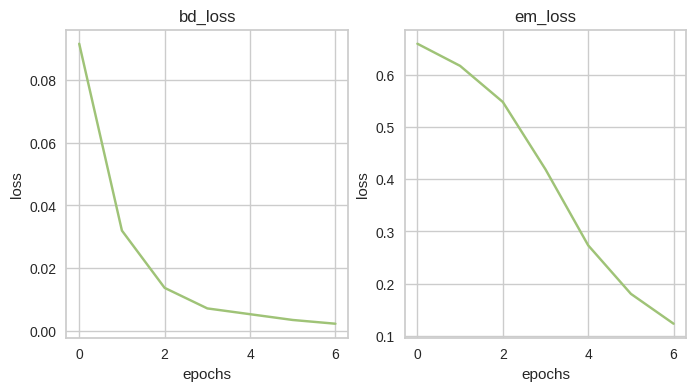

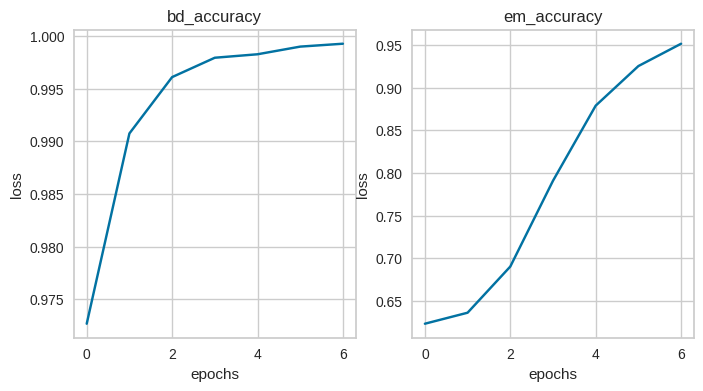

In [43]:
#print(history.history['bd_loss'])
plot_history(history)

In [44]:
y_pred = [idx for idx in np.argmax(predictions[1], axis=1)]
res_df['Disagreement_Labels'] = y_pred
print('Disagreement Detection Accuracy is')
print(metrics.accuracy_score(Y_bd_test, y_pred)*100)
print(classification_report(Y_bd_test, y_pred, target_names = ['agreed', 'disagreed']))

Disagreement Detection Accuracy is
98.64328950114799
              precision    recall  f1-score   support

      agreed       0.99      0.99      0.99     27075
   disagreed       0.88      0.89      0.88      1671

    accuracy                           0.99     28746
   macro avg       0.94      0.94      0.94     28746
weighted avg       0.99      0.99      0.99     28746



[[26877   198]
 [  192  1479]]


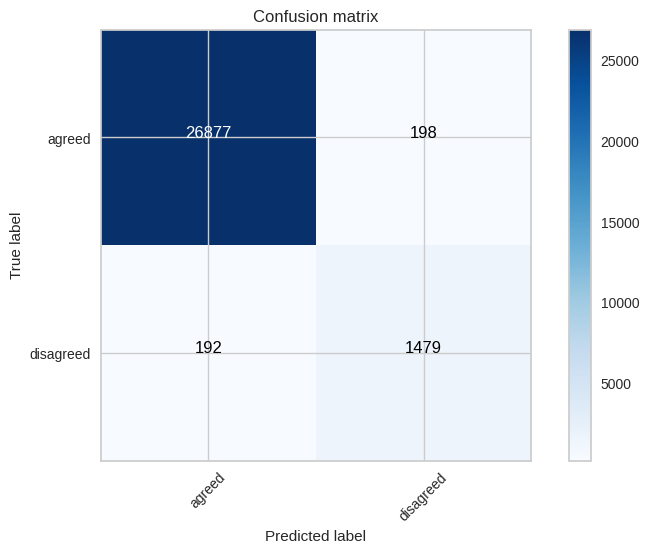

In [45]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(Y_bd_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le.inverse_transform(np.arange(2)))

In [46]:
y_pred = [idx for idx in np.argmax(predictions[0], axis=1)]
res_df['Emotion_Labels'] = y_pred
print('Emotion Recognition Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred)*100)
print(classification_report(Y_em_test, y_pred, target_names = ['agree', 'disagree']))

Emotion Recognition Accuracy is
77.25596604745007
              precision    recall  f1-score   support

       agree       0.81      0.86      0.83     19132
    disagree       0.68      0.61      0.64      9614

    accuracy                           0.77     28746
   macro avg       0.75      0.73      0.74     28746
weighted avg       0.77      0.77      0.77     28746



[[16383  2749]
 [ 3789  5825]]


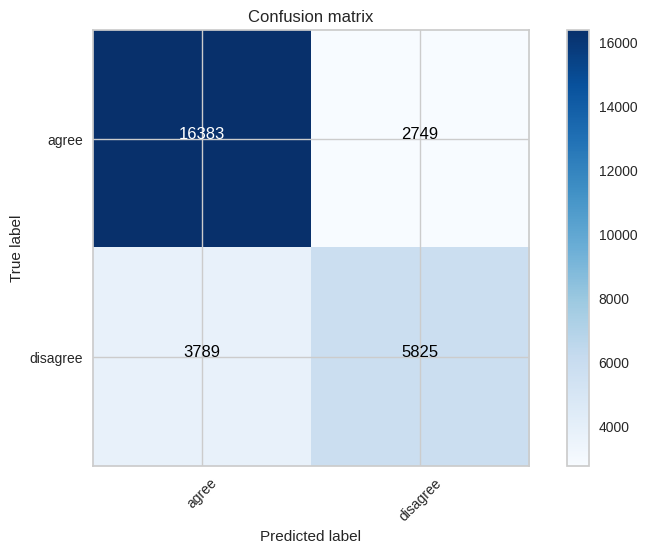

In [47]:
cnf_matrix = confusion_matrix(Y_em_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=['agree','disagree'])

In [48]:
# Saving the labels
res_df.to_csv("BD_Multitask_two_tasks_results.csv", index = False)